# 3. Example: ETK DA using Reservoir Computing ML Model

So far, our "forecast model" has been the same model used to generate the nature run data. In practical application, this isn't possible. In this example, we'll complicate things by training and using a Reservoir Computing Machine Learning Model. RC models are a type of relatively simple Neural Network that tend to perform very well in DA tasks.

In [24]:
import dabench as dab
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rc import RCModel

## A. Create Nature Run


In [2]:
train_size = 100000
transient_size = 1000
test_size = 2000

In [3]:
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [4]:
nature_run.generate(n_steps=(train_size + transient_size + test_size))

In [22]:
# Dabench has a simple way of splitting the generated data into train/val/test
nr_train, nr_transient, nr_test = nature_run.split_train_valid_test(train_size, transient_size, test_size)

## B. Generate observations: Only on test set

In [14]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, 2000, 5), # Observation every other timestep
    random_location_count = 3, # Probability of picking each location in l63.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 0.5, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=91, # We can specify a random seed. Default is 99
    stationary_observers=True,
    store_as_jax=True
)

# Making observations
obs_vec_l96 = obs_l96.observe()

## C. Define AND train model

In [6]:
our_rc_model = RCModel(system_dim=6, 
                reservoir_dim=1600, 
                input_dim=6, 
                sparse_adj_matrix=False, 
                sparsity=0.99,
                readout_method='linear',
                sigma=0.07,
                spectral_radius = 0.1, 
                leak_rate=0.7,
                log_beta=-18.41)

In [7]:
our_rc_model.weights_init()

In [8]:
our_rc_model.generate(nr_train.values, save_states=True)

In [9]:
our_rc_model.train(nr_train)

Predict Forward to see how our model does without DA

In [10]:
our_rc_model.generate(nr_test.values, save_states=True)  
out_obj = our_rc_model.predict(nr_test, delta_t = 0.01, n_steps = 1000, initial_index=1000, spinup_steps=1000)

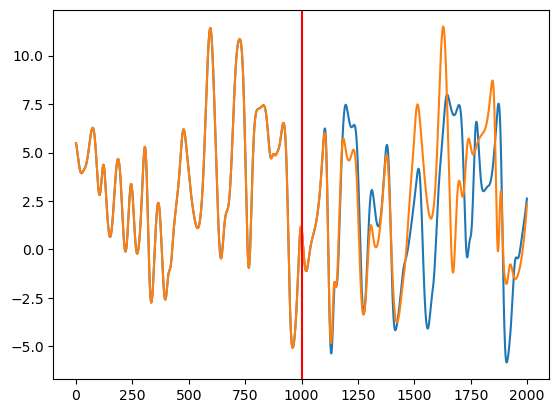

In [11]:
plt.plot(nr_test.values[:, 0])
plt.plot(out_obj.values[:, 0])
plt.axvline(1000, color='red')

Wrap as dab.model.Model object

In [23]:
class RCModelForecaster(dab.model.Model):                                                                       
    """Defines model wrapper for RC Model"""
    def forecast(self, state_vec):
        new_vals = self.model_obj.update(state_vec.values, self.model_obj.readout(state_vec.values))      

        new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

        return new_vec

In [13]:
forecast_model = RCModelForecaster(model_obj=our_rc_model)

## D. Set up and run DA Cycler

### I. Observation Operator

In [15]:
S = jnp.zeros((6, 6))
S = S.at[jnp.arange(S.shape[0]), np.tile(obs_vec_l96.location_indices[0], 2)
             ].set(1)
H = S @ our_rc_model.Wout.T

In [16]:
S.shape

(6, 6)

### II. Define DA Cycler

In [17]:
dc = dab.dacycler.ETKF(system_dim=our_rc_model.reservoir_dim,#nature_run.system_dim, # 6
                   delta_t=nature_run.delta_t,
                   H=H,
                   model_obj=forecast_model, # Forecast model we created above
                   ensemble_dim=10 # Ensemble dim for Ensemble Kalman Filter
                  )


### III.  Generate perturbed initial conditions

In [18]:
ics = jnp.stack([
    our_rc_model.generate(
        nr_transient.values
        + np.random.normal(size = (nr_transient.time_dim, nr_transient.system_dim), scale=3.0))[-1]
    for i in range(10)])

### IV. Run DA Cycler

In [19]:
%%time

# Needs to be at least 1 otherwise unequal number of obs per cycle
cur_tstep = 1

# ETKF input state is an ensemble with error
etkf_x0 = dab.vector.StateVector(
    values=ics,
    store_as_jax=True)

# Run cycler for 1500 timesteps
out_statevec = dc.cycle(
    input_state = etkf_x0,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96,
    obs_error_sd = 1.0,
    analysis_window=0.1, 
    timesteps=1500)

CPU times: user 27.3 s, sys: 1.19 s, total: 28.5 s
Wall time: 27.1 s


## V. Plot Results

In [20]:
# Transform to system space:
out_statevals = np.zeros((out_statevec.time_dim, out_statevec.values.shape[1], 6))
for i in range(out_statevec.values.shape[0]):
    for j in range(out_statevec.values.shape[1]):
        out_statevals[i, j] = our_rc_model.readout(jnp.array(out_statevec.values[i,j]))

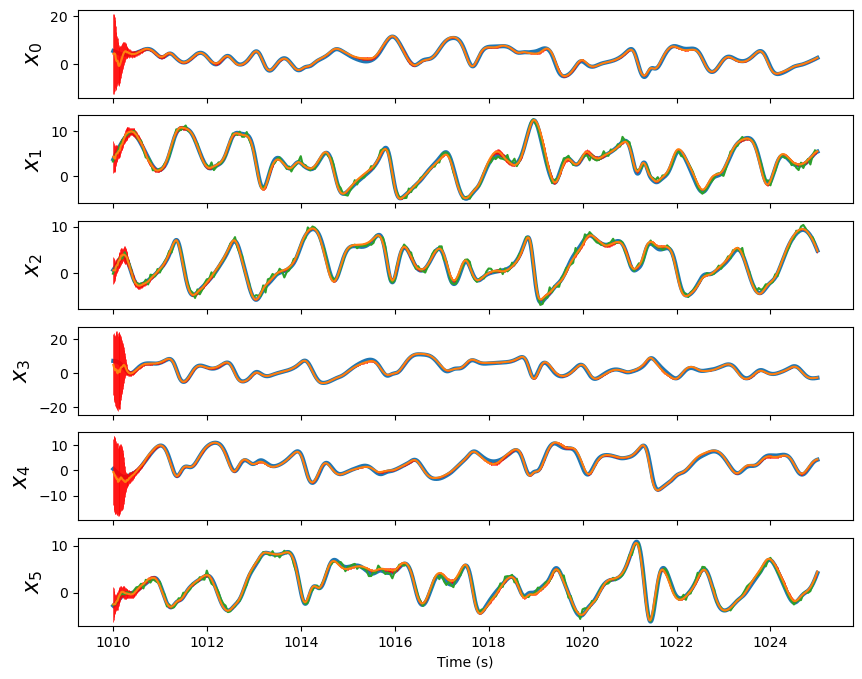

In [21]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times[:1500], nr_test.values[1:1501,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times[:1500], np.mean(out_statevals, axis=1)[:4000,j],
                yerr=np.ptp(out_statevals, axis=1)[:1500,j], elinewidth=0.5, ecolor='red')
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times[:300], obs_vec_l96.values[:300, np.where(j == obs_vec_l96.location_indices[0])[0]])
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.set_xlabel('Time (s)')
plt.show()